<a href="https://colab.research.google.com/github/invincible/wall-e/blob/main/Project_Colorizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
from tensorflow.keras.layers import BatchNormalization,Dropout,MaxPooling2D,Reshape, Input, concatenate,Embedding,multiply,Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LeakyReLU,ReLU, UpSampling2D, Conv2D,Conv2DTranspose,Concatenate,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import datetime,os,time
from tensorflow import image,stack,GradientTape,function,summary,train,random,data,errors
from IPython import display
from tensorflow import random_normal_initializer,reduce_mean,abs,ones_like,zeros_like


In [32]:
IMG_HEIGHT=256
IMG_WIDTH=256
image_shape=[IMG_HEIGHT,IMG_WIDTH,3]
OUTPUT_CHANNELS=3
BUFFER_SIZE=400
BATCH_SIZE=1
PATH='Путь до картинок'
LAMBDA=100
object_loss=BinaryCrossentropy(from_logits=True)

**Подготовка изображений для создания обучающей и проверочной выборок**






In [29]:
def load(img_BW,img_COL):
  #Загрузка чб фото и ее цветного аналога
  return img_BW,img_COL

In [8]:
def resize(input_image, real_image, height, width):
  input_image = image.resize(input_image, [height, width],
                                method=image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = image.resize(real_image, [height, width],
                               method=image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [9]:
def random_crop(input_image, real_image):
  stacked_image = stack([input_image, real_image], axis=0)
  cropped_image = image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [10]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [11]:
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if random.uniform(()) > 0.5:
    # Random mirroring
    input_image = image.flip_left_right(input_image)
    real_image = image.flip_left_right(real_image)

  return input_image, real_image

In [12]:
def load_image_train(image_file):
  input_image, real_image = load(train)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = data.Dataset.list_files(PATH + 'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
try:
  test_dataset = data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except errors.InvalidArgumentError:
  test_dataset = data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

**Определим функции создания блоков модели Генератора**

In [13]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(BatchNormalization())

  result.add(LeakyReLU())

  return result

In [14]:
def upsample(filters, size, apply_dropout=False):
  initializer = random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(BatchNormalization())

  if apply_dropout:
      result.add(Dropout(0.5))

  result.add(ReLU())

  return result

**Создадим модель генератора**

In [15]:
def Generator():
  inputs = Input(shape=image_shape)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(OUTPUT_CHANNELS, 4,strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])

  x = last(x)

  return Model(inputs=inputs, outputs=x)

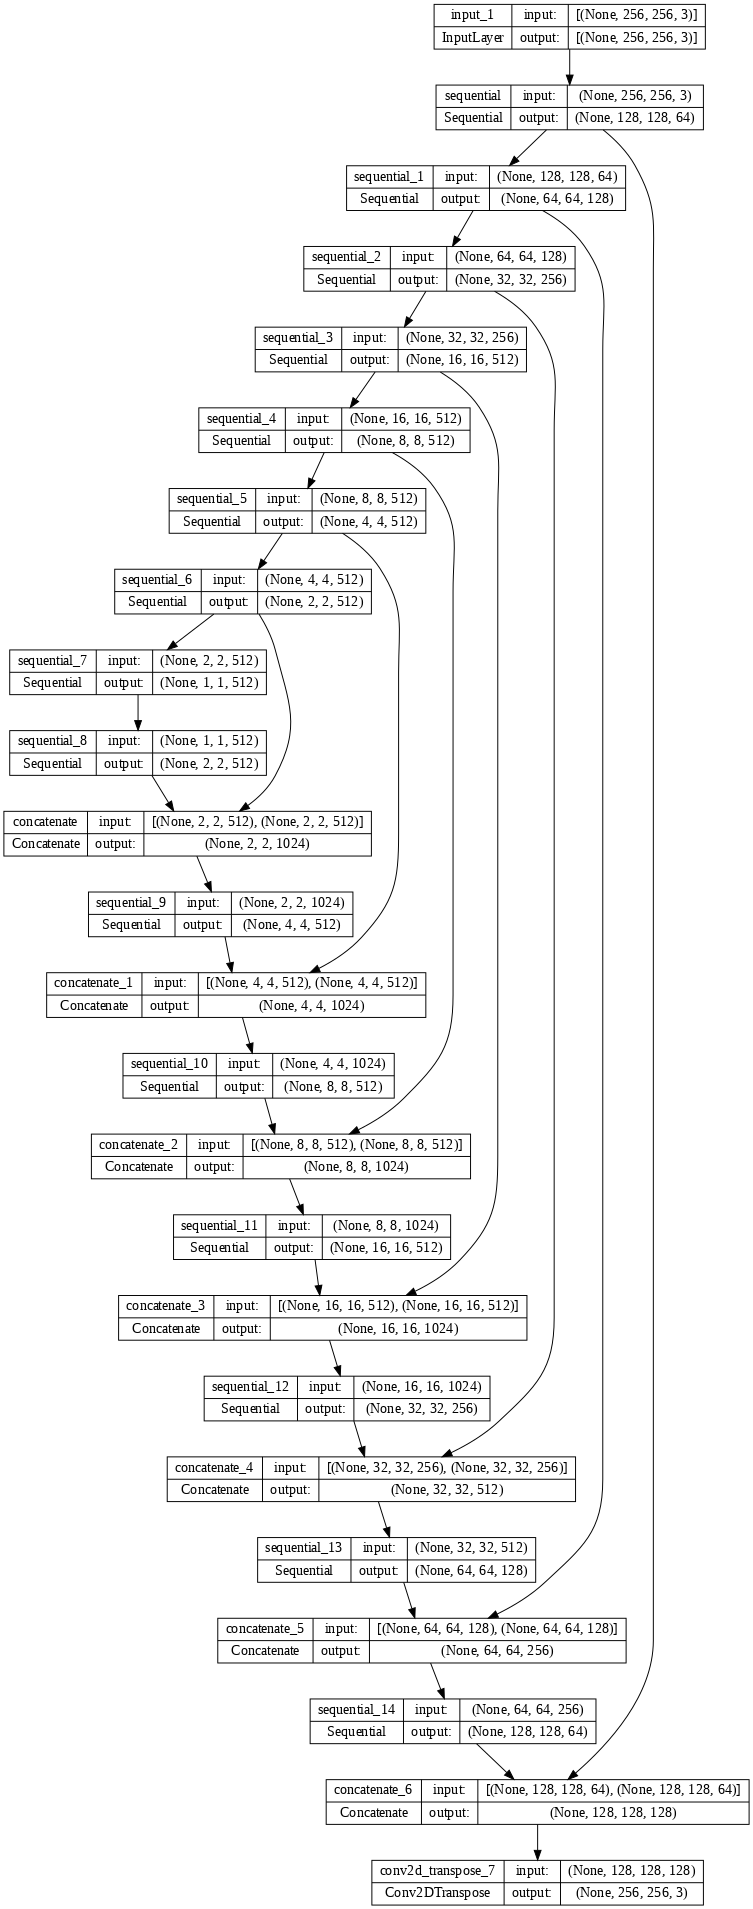

In [16]:
generator=Generator()
plot_model(generator,show_shapes=True,dpi=70)

In [17]:

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = object_loss(ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = reduce_mean(abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

**Создадим модель Дискриминатора**

In [18]:
def Discriminator():
  initializer = random_normal_initializer(0., 0.02)

  inp = Input(shape=[256, 256, 3], name='input_image')
  tar = Input(shape=[256, 256, 3], name='target_image')

  x = concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = Conv2D(512, 4, strides=1,kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = BatchNormalization()(conv)

  leaky_relu = LeakyReLU()(batchnorm1)

  zero_pad2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return Model(inputs=[inp, tar], outputs=last)


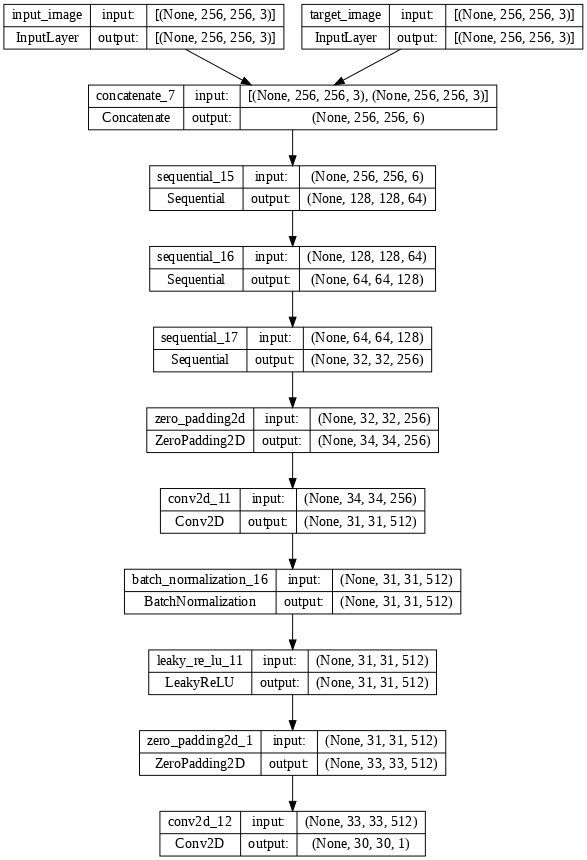

In [19]:
discriminator=Discriminator()
plot_model(discriminator,show_shapes=True,dpi=70)

In [20]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = object_loss(ones_like(disc_real_output), disc_real_output)

  generated_loss = object_loss(zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [21]:
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

In [22]:
#функция генерации изображений из обученного генератора
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [23]:

log_dir="/content/logs"

summary_writer = summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [24]:
@function
def train_step(input_image, target, step):
  with GradientTape() as gen_tape, GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    summary.scalar('disc_loss', disc_loss, step=step//1000)

In [25]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


In [33]:
fit(train_dataset, test_dataset, steps=40000)

NameError: ignored